# [Lab Session 4](deconvolution.ipynb)

In [135]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import wiener
from scipy.signal import convolve2d as conv
from scipy.stats import multivariate_normal as multi_normal

np.random.seed(0)

Load the image.

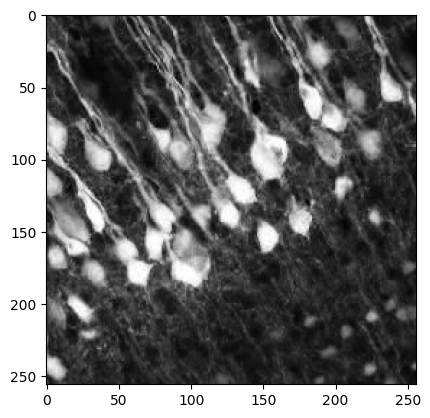

In [136]:
img = plt.imread('data/cells.png')[128:384, 128:384]
plt.imshow(img, 'gray')

**[Task 1.]()** Apply the following PSF to the image and then display it.

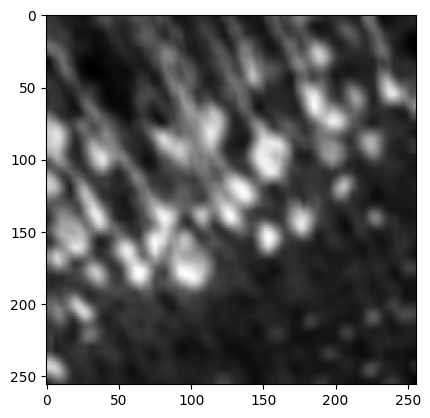

In [137]:
psf_size = 10
psf = np.ones((psf_size, psf_size)) / psf_size ** 2 # PSF = Point Spread Function — beschreibt, wie ein idealer Punkt im Objekt durch das Aufnahme‑/Abbildungsystem verteilt (verschwommen) wird.

conv_img_uni  = conv(img, psf, mode='same', boundary='symm') # → Bild wird mit PSF gefaltet; mode='same' gibt Bildgröße zurück; boundary='symm' spiegelt Ränder zur Randbehandlung.

plt.imshow(conv_img_uni, 'gray')
plt.show()

**[Task 2.]()** Have a look at the Gaussian PSF which is not uniformly distributed. Apply it to the image.

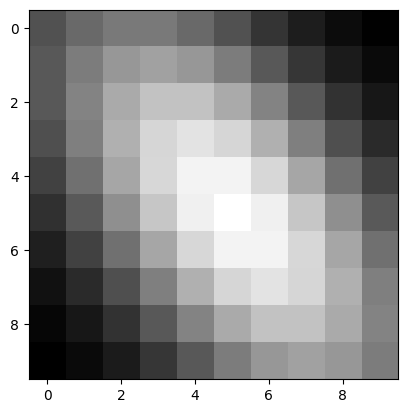

In [138]:
def create_psf(size):
    factor = size * 1.8
    x, y = np.mgrid[0:size:1, 0:size:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multi_normal([int(size / 2), (int(size / 2))], [[factor * 1., factor * 1.2], [factor * .5, factor * .7]])
    return rv.pdf(pos)

plt.imshow(create_psf(psf_size), 'gray')

Apply the second psf to the image:

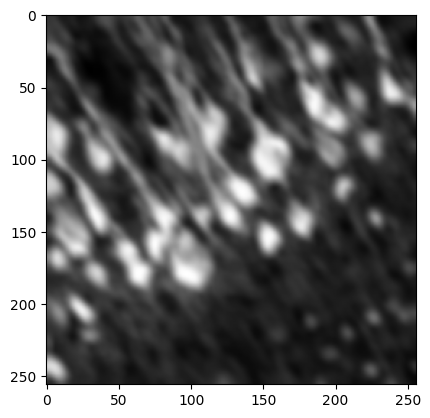

In [139]:
conv_img_gauss  = conv(img, create_psf(psf_size), mode='same', boundary='symm')

plt.imshow(conv_img_gauss, 'gray')
plt.show()

**[Task 3.]()** Implement a reusable function that performs the Richardson-Lucy deconvolution.

In [ ]:
def richardson_lucy_deconvolution(image, psf, n_iterations):
    img_deconv = np.full(image.shape, 0.5)
    psf_flipped = np.flip(psf) # psf_flipped = np.flip(psf) (P* in Formel).
    
    for _ in range(n_iterations):
        img_deconv = img_deconv * (conv(image / conv(img_deconv, psf, mode='same', boundary='symm'), psf_flipped, mode='same', boundary='symm')) # h(t+1) = h(t) · (g / (h(t) ∗ P)) ∗ P*

# h(t) = deconvolvierte Schätzung des Originalbildes bei Iteration t
# g = verschwommenes Eingabebild (beobachtete Daten)
# P = Point Spread Function (PSF, der "Blur-Kernel")
# P* = flip(P), die gespiegelte PSF
# ∗ = Faltungsoperation (convolution)
# / = elementweise Division
# · = elementweise Multiplikation

    img_deconv = img_deconv.clip(0,1)
    return img_deconv

**[Task 4.]()** Apply the Richardson-Lucy deconvolution to the blurred image.

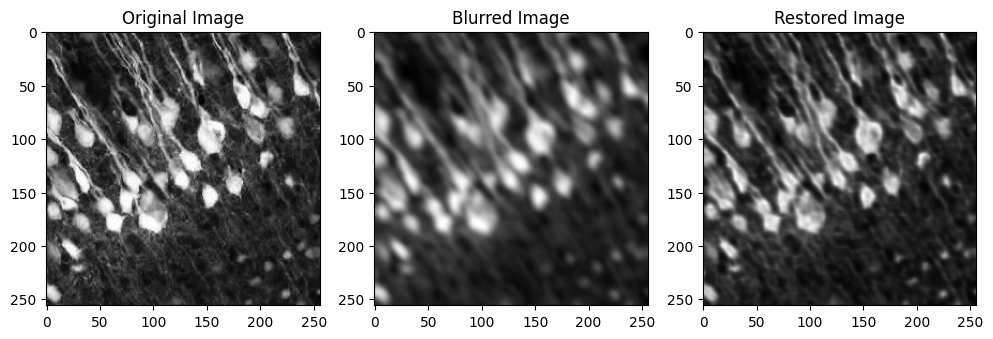

In [141]:
# Restore the image using your IDFT function and display it
deconv_img = richardson_lucy_deconvolution(conv_img_gauss, create_psf(psf_size), 100)

# Display the original, the blurred, and the restored image side by
# side. Try different values for the number of iterations for the R-L algorithm

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img, 'gray')
plt.subplot(1, 3, 2)
plt.title('Blurred Image')
plt.imshow(conv_img_gauss, 'gray')
plt.subplot(1, 3, 3)
plt.title('Restored Image')
plt.imshow(deconv_img, 'gray')
plt.show()



In [142]:
# plt.figure(figsize=(20,5))
#plt.subplot(1, 3, 1)
# plt.axis('off')
# plt.imshow(img, 'gray')
# plt.title('Original image')
# plt.subplot(1, 3, 2)
# plt.axis('off')
# plt.imshow(img_psf, 'gray')
# plt.title('Blurred image')
# plt.subplot(1, 3, 3)
# plt.axis('off')
# plt.imshow(deconv_img, 'gray')
# plt.title('R-L deconvolution')
# plt.show()

**[Task 5.]()** Add noise to the image, use the R-L deconvolution again.

In [143]:
noise = (np.random.normal(loc=0,size=img.shape))
reduce_factor = 5
noise = noise / reduce_factor

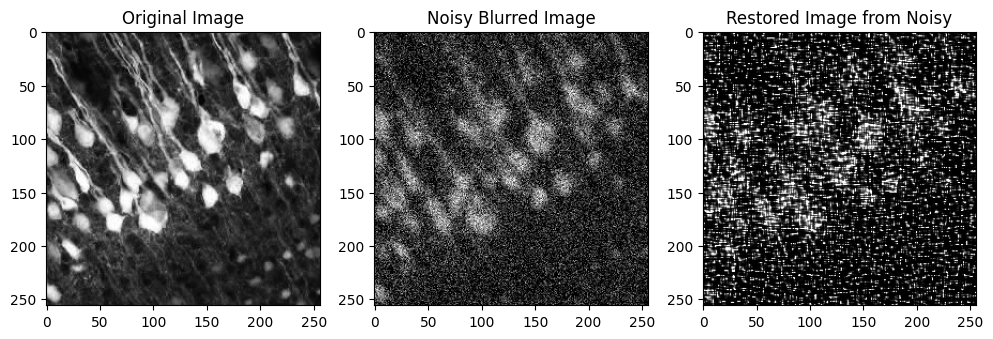

In [144]:
# Add white noise to the blurred image generated in Task 2 as an additive com-
# ponent (the white noise is already generated in the notebook). To ensure that
# the image intensities remain in the interval [0, 1] remember to perform intensity
# clipping after adding the noise. Repeat the R-L deconvolution for the noisy im-
# age and display the result as before. Try a different noise level by changing the
# variable reduce_factor (larger values correspond to lower noise levels).

noisy_blurred_img = conv_img_gauss + noise
noisy_blurred_img = noisy_blurred_img.clip(0,1)

deconv_noisy_img = richardson_lucy_deconvolution(noisy_blurred_img, create_psf(psf_size), 100)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img, 'gray')
plt.subplot(1, 3, 2)
plt.title('Noisy Blurred Image')
plt.imshow(noisy_blurred_img, 'gray')
plt.subplot(1, 3, 3)
plt.title('Restored Image from Noisy')
plt.imshow(deconv_noisy_img, 'gray')
plt.show()

**[Task 6.]()** Compare your R-L implementation to a wiener deconvolution.

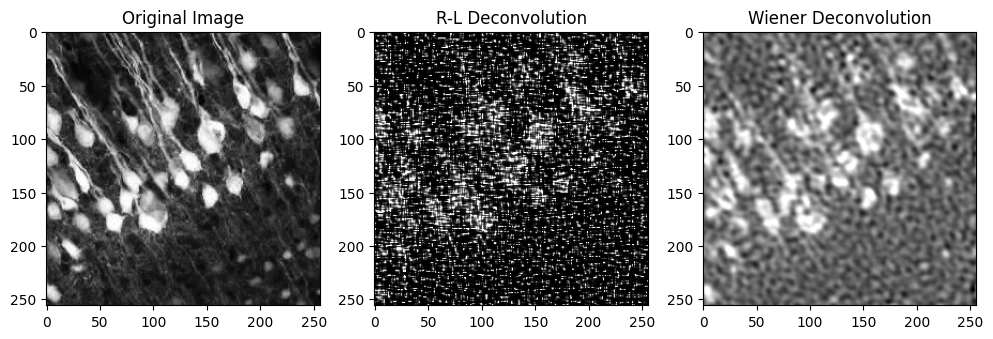

In [145]:
# Compare the result of your R-L implementation to that of the Wiener deconvo-
# lution, which you can use by wiener(img_psf, psf, balance=2, clip=True).
# The corresponding function wiener is pre-implemented. Display the original
# image beside the R-L reconstruction and the Wiener reconstruction. – Hint: You
# can try different values for the parameter balance to achieve better results.

wiener_deconv_img = wiener(noisy_blurred_img, create_psf(psf_size), balance=0.1, clip=True)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img, 'gray')
plt.subplot(1, 3, 2)
plt.title('R-L Deconvolution')
plt.imshow(deconv_noisy_img, 'gray')
plt.subplot(1, 3, 3)
plt.title('Wiener Deconvolution')
plt.imshow(wiener_deconv_img, 'gray')
plt.show()

**[Task 7.]()** Repeat Tasks 4–6 using a smaller value for the size of the PSF.

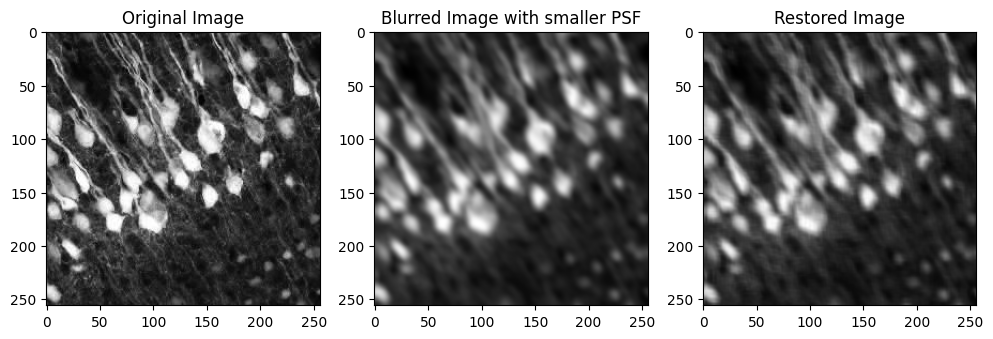

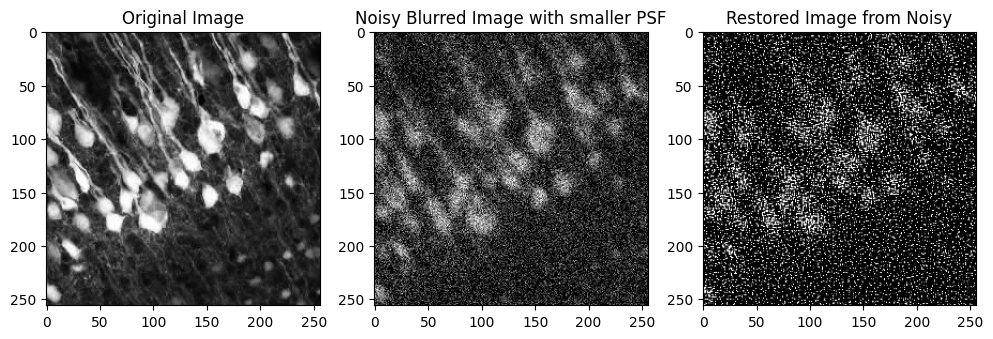

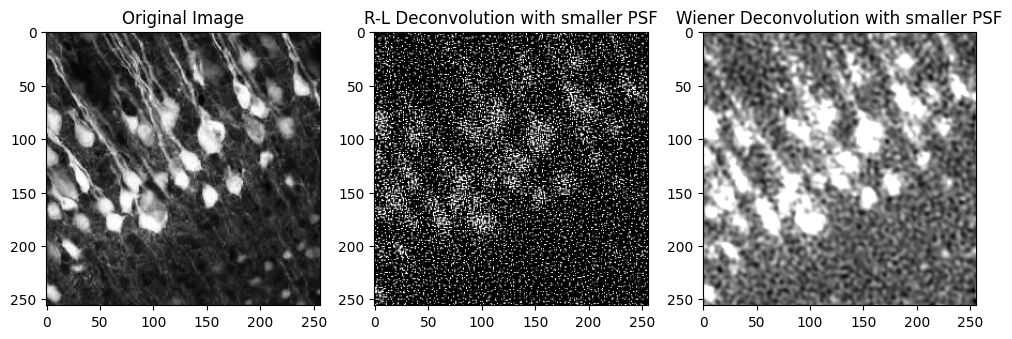

In [146]:
# Repeat tasks 4-6 using a smaller value for the size of the PSF (e.g., 5).
deconv_img = richardson_lucy_deconvolution(conv_img_gauss, create_psf(5), 100)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img, 'gray')
plt.subplot(1, 3, 2)
plt.title('Blurred Image with smaller PSF')
plt.imshow(conv_img_gauss, 'gray')
plt.subplot(1, 3, 3)
plt.title('Restored Image')
plt.imshow(deconv_img, 'gray')
plt.show()

deconv_noisy_img = richardson_lucy_deconvolution(noisy_blurred_img, create_psf(5), 100)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img, 'gray')
plt.subplot(1, 3, 2)
plt.title('Noisy Blurred Image with smaller PSF')
plt.imshow(noisy_blurred_img, 'gray')
plt.subplot(1, 3, 3)
plt.title('Restored Image from Noisy')
plt.imshow(deconv_noisy_img, 'gray')
plt.show()

wiener_deconv_img = wiener(noisy_blurred_img, create_psf(5), balance=0.1, clip=True)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img, 'gray')
plt.subplot(1, 3, 2)
plt.title('R-L Deconvolution with smaller PSF')
plt.imshow(deconv_noisy_img, 'gray')
plt.subplot(1, 3, 3)
plt.title('Wiener Deconvolution with smaller PSF')
plt.imshow(wiener_deconv_img, 'gray')
plt.show()




**[Task 8.]()** Use a wrong PSF to restore the image

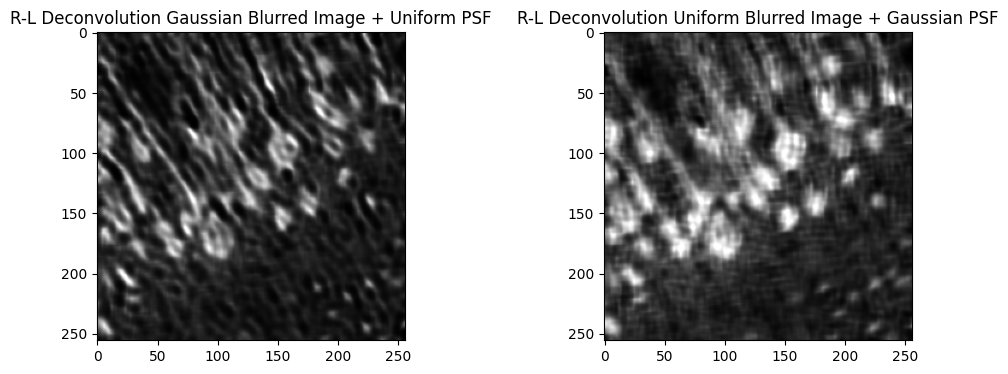

In [148]:
# Try using a “wrong” PSF for the R-L deconvolution and observe the impact.
# Display both, the R-L reconstruction using the uniform PSF for the image blurred
# with the Gaussian PSF, and the other way round.
deconv_wrong_psf1 = richardson_lucy_deconvolution(conv_img_gauss, psf, 100)
deconv_wrong_psf2 = richardson_lucy_deconvolution(conv_img_uni, create_psf(psf_size), 100)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('R-L Deconvolution Gaussian Blurred Image + Uniform PSF')
plt.imshow(deconv_wrong_psf1, 'gray')
plt.subplot(1, 2, 2)
plt.title('R-L Deconvolution Uniform Blurred Image + Gaussian PSF')
plt.imshow(deconv_wrong_psf2, 'gray')
plt.show()